# Dependencies

In [1]:
import os, warnings, shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tokenizers import ByteLevelBPETokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *


SEED = 0
warnings.filterwarnings("ignore")

# Load data

In [2]:
train_df = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')

# Sample data by lower bound
lower_count = min(len(train_df[train_df['sentiment'] == 'neutral']), 
                  len(train_df[train_df['sentiment'] == 'negative']), 
                  len(train_df[train_df['sentiment'] == 'positive']))

train_df = pd.concat([train_df[train_df['sentiment'] == 'neutral'].sample(n=lower_count, random_state=SEED),
                      train_df[train_df['sentiment'] == 'negative'].sample(n=lower_count, random_state=SEED),
                      train_df[train_df['sentiment'] == 'positive'].sample(n=lower_count, random_state=SEED),
                     ])
train_df = shuffle(train_df, random_state=SEED).reset_index(drop=True)

# pre-process
train_df.dropna(inplace=True)
train_df = train_df.reset_index()
train_df.drop('index', axis=1, inplace=True)
train_df["text"] = train_df["text"].apply(lambda x: x.strip())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.strip())
train_df["text"] = train_df["text"].apply(lambda x: x.lower())
train_df["selected_text"] = train_df["selected_text"].apply(lambda x: x.lower())

train_df['jaccard'] = train_df.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)

train_df['text_len'] = train_df['text'].apply(lambda x : len(x))
train_df['selected_text_len'] = train_df['selected_text'].apply(lambda x : len(x))
train_df['text_wordCnt'] = train_df['text'].apply(lambda x : len(x.split(' ')))
train_df['selected_text_wordCnt'] = train_df['selected_text'].apply(lambda x : len(x.split(' ')))

sentiment_cols = train_df['sentiment'].unique()

print('Train samples: %s' % len(train_df))
display(train_df.head())

Train samples: 23342


,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt
0,6c3221ae9b,so instead of laying out in this 90 degrees i`...,fml,negative,0.052632,115,3,21,1
1,6d059e310b,hitting the (fairly empty) shops in orlando! o...,hitting,negative,0.076923,100,7,14,1
2,ce7f8a5210,spent some time with the guild wars 4th birthd...,welcome,positive,0.052632,114,7,19,1
3,456c4304cd,first weekend at home,first weekend at home,neutral,1.000000,21,21,4,4
4,6b78e2821a,would like june the nineteenth to hurry it sel...,she is waiting very impatiently,negative,0.263158,102,31,20,5


# Tokenizer

In [3]:
MAX_LEN = 96
base_path = '/kaggle/input/qa-transformers/roberta/'
vocab_path = base_path + 'roberta-base-vocab.json'
merges_path = base_path + 'roberta-base-merges.txt'

tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Tokenizer sanity check

In [4]:
for idx in range(10):
    print('\nRow %d' % idx)
    max_seq_len = 40
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    
    _, (target_start, target_end, _) = preprocess_roberta(' ' + text, selected_text, ' ' + question, tokenizer, max_seq_len)
    
    question_encoded = tokenizer.encode(question).ids
    question_size = len(question_encoded) + 3
    
    decoded_text = decode(target_start.argmax(), target_end.argmax(), text, question_size, tokenizer)
    
    print('text         : "%s"' % text)
    print('selected_text: "%s"' % selected_text)
    print('decoded_text : "%s"' % decoded_text)
    
    assert selected_text == decoded_text


Row 0
text         : "so instead of laying out in this 90 degrees i`ve gotta give 32 fourth graders miso/rice/sushi/mochi in an hour  fml"
selected_text: "fml"
decoded_text : "fml"

Row 1
text         : "hitting the (fairly empty) shops in orlando! off to downtown disney later  http://tinyurl.com/cdsuws"
selected_text: "hitting"
decoded_text : "hitting"

Row 2
text         : "spent some time with the guild wars 4th birthday update. menagerie is a welcome new feature... for rangers anyway."
selected_text: "welcome"
decoded_text : "welcome"

Row 3
text         : "first weekend at home"
selected_text: "first weekend at home"
decoded_text : "first weekend at home"

Row 4
text         : "would like june the nineteenth to hurry it self up, as she is waiting very impatiently to see wes carr"
selected_text: "she is waiting very impatiently"
decoded_text : "she is waiting very impatiently"

Row 5
text         : "you realize you just did  a solid. better than a full-page in the ajc."
selected_t

## Data generation sanity check

In [5]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 40
    text = train_df['text'].values[idx]
    selected_text = train_df['selected_text'].values[idx]
    question = train_df['sentiment'].values[idx]
    jaccard = train_df['jaccard'].values[idx]
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_df[idx:idx+1], tokenizer, max_seq_len, 
                                                                         preprocess_fn=preprocess_roberta)
    
    print('text          : "%s"'   % text)
    print('jaccard       : "%.4f"' % jaccard)
    print('input_ids     : "%s"'   % x_train[0][0])
    print('attention_mask: "%s"'   % x_train[1][0])
    print('sentiment     : "%s"'   % x_train_aux[0][0])
    print('word count    : "%s"'   % x_train_aux[1][0])
    print('sentiment OHE : "%s"'   % x_train_aux_2[0])
    
    print('selected_text : "%s"'   % selected_text)
    print('start         : "%s"'   % y_train[0][0])
    print('end           : "%s"'   % y_train[1][0])
    print('mask          : "%s"'  % y_train_mask[0])
    print('jaccard       : "%.4f"' % y_train_aux[0])
    
    assert len(x_train) == 2
    assert len(x_train_aux) == 2
    assert len(x_train_aux_2) == 1
    assert len(y_train) == 2
    assert len(y_train_mask) == 1
    assert len(y_train_aux) == 1
    
    assert len(x_train[0][0]) == len(x_train[1][0]) == max_seq_len
    assert len(y_train[0][0]) == len(y_train[1][0]) == len(y_train_mask[0]) == max_seq_len


Row 0
text          : "so instead of laying out in this 90 degrees i`ve gotta give 32 fourth graders miso/rice/sushi/mochi in an hour  fml"
jaccard       : "0.0526"
input_ids     : "[    0  2430     2     2    98  1386     9 11963    66    11    42  1814
  4176   939 12905   548 16112   492  2107   887 12003   268  3834   139
    73 15474    73    29 23947    73   119  4306   118    11    41  1946
  1437   856 18517     2]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1]"
sentiment     : "0"
word count    : "1"
sentiment OHE : "[1 0 0]"
selected_text : "fml"
start         : "[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0]"
end           : "[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0]"
mask          : "[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0]"
jaccard       : "0.0526"

Row 1
text          : "hitting the (fairly empty) sho

# 5-Fold split

In [6]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

for fold_n, (train_idx, val_idx) in enumerate(folds.split(train_df, train_df['sentiment'])):
    print('Fold: %s, Train size: %s, Validation size %s' % (fold_n+1, len(train_idx), len(val_idx)))
    train_df[('fold_%s' % str(fold_n+1))] = 0
    train_df[('fold_%s' % str(fold_n+1))].loc[train_idx] = 'train'
    train_df[('fold_%s' % str(fold_n+1))].loc[val_idx] = 'validation'

Fold: 1, Train size: 18673, Validation size 4669
Fold: 2, Train size: 18673, Validation size 4669
Fold: 3, Train size: 18674, Validation size 4668
Fold: 4, Train size: 18674, Validation size 4668
Fold: 5, Train size: 18674, Validation size 4668


## Sentiment distribution

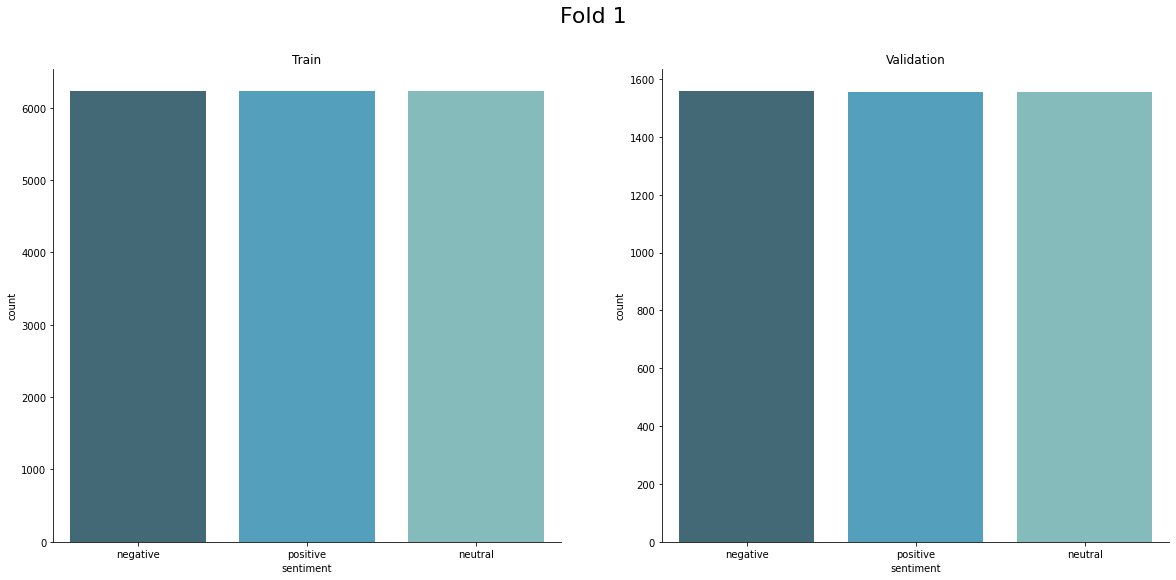

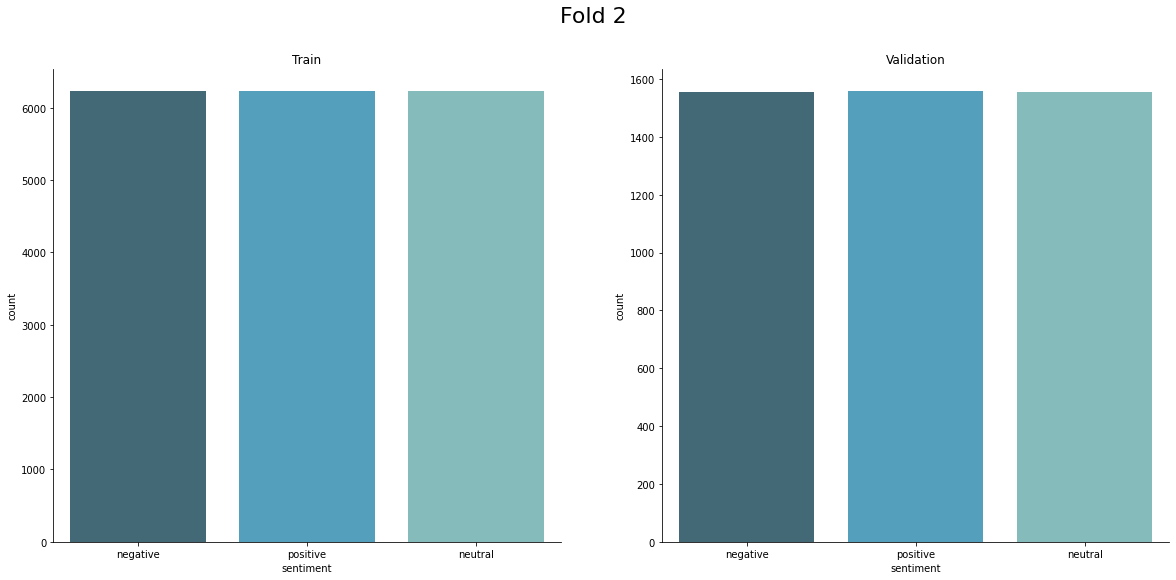

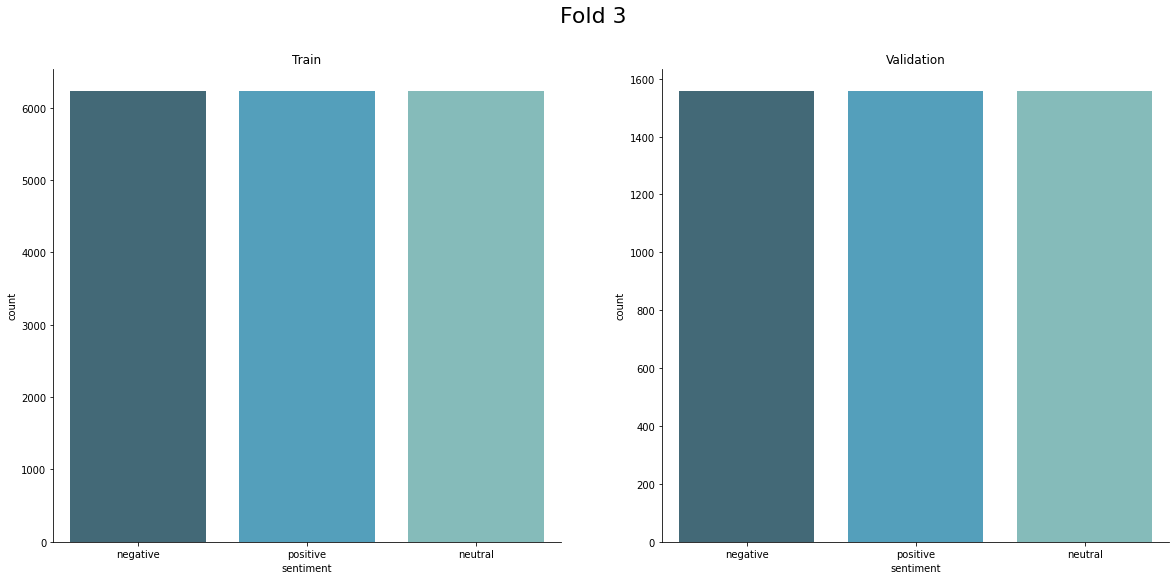

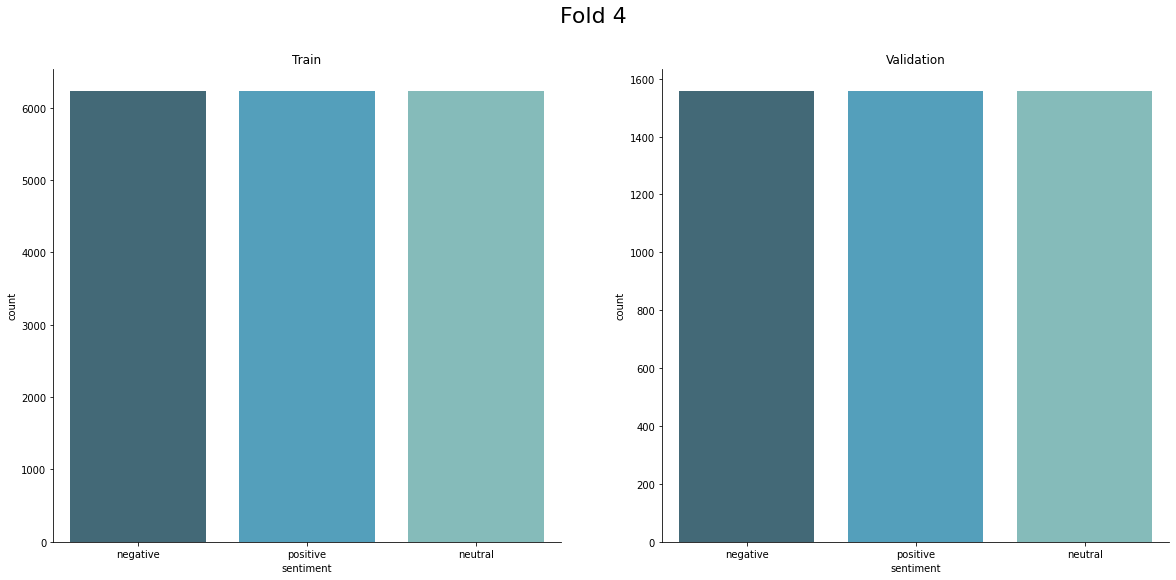

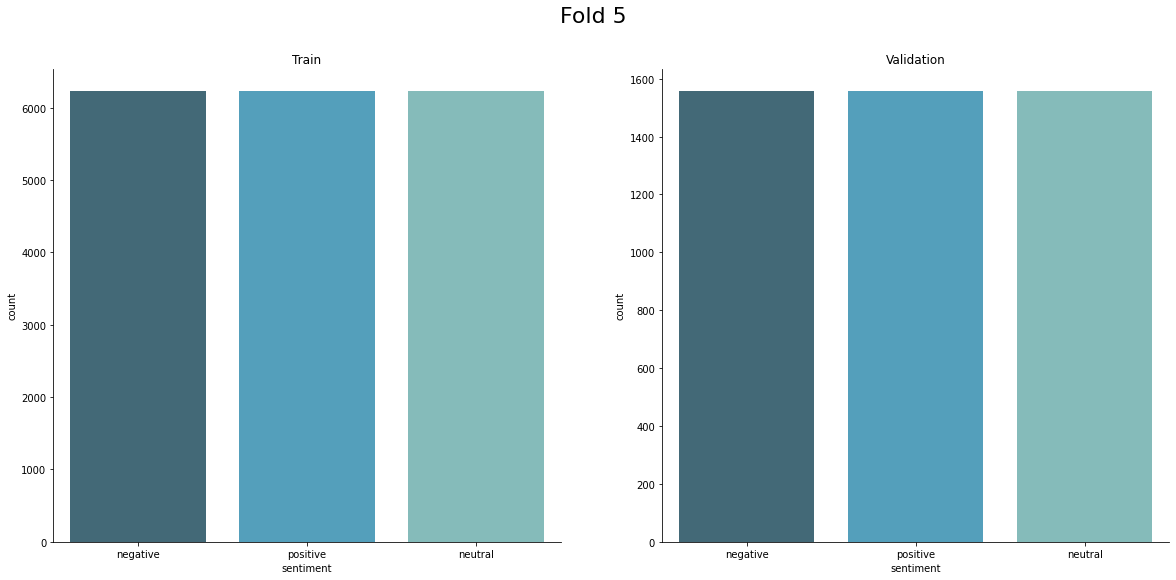

In [7]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8.7))
    fig.suptitle('Fold %s' % fold_n, fontsize=22)    
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'train'], palette="GnBu_d", order=sentiment_cols, ax=ax1).set_title('Train')
    sns.countplot(x="sentiment", data=train_df[train_df[('fold_%s' % fold_n)] == 'validation'], palette="GnBu_d", order=sentiment_cols, ax=ax2).set_title('Validation')
    sns.despine()
    plt.show()

## Word count distribution

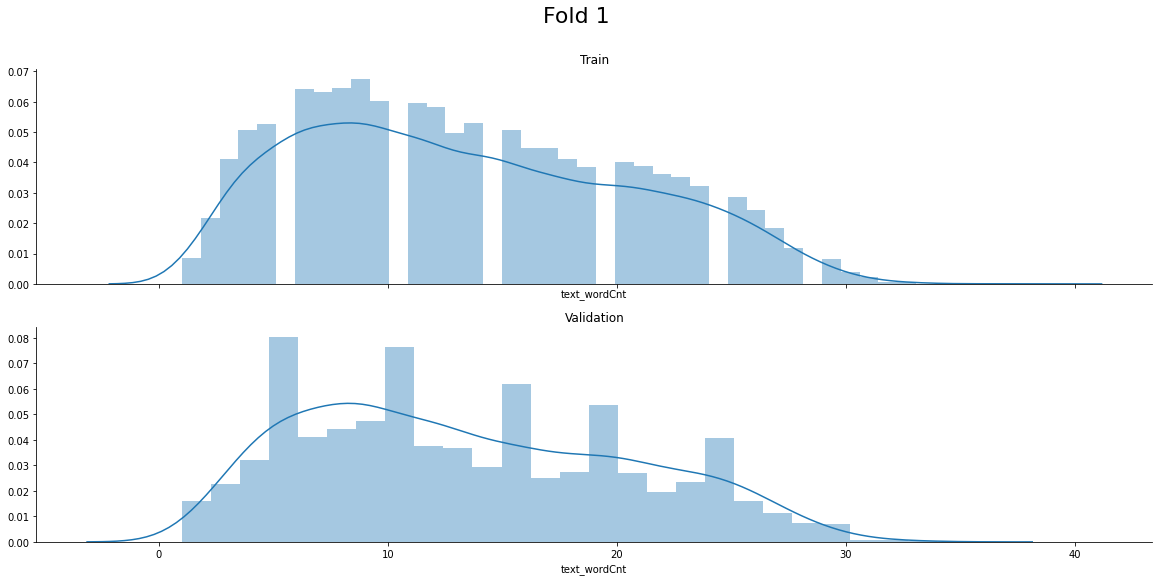

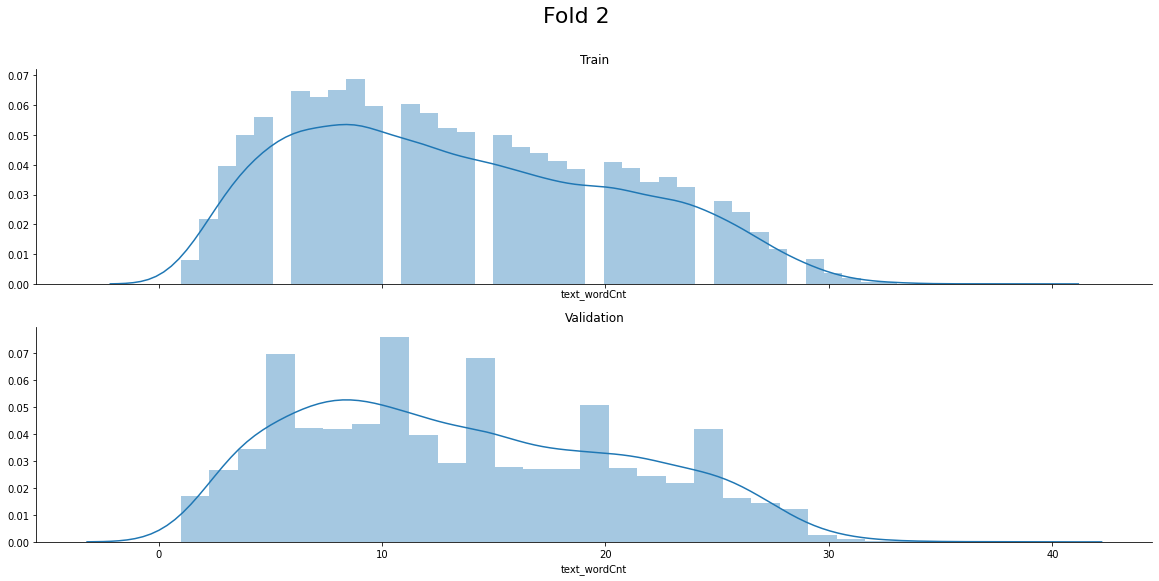

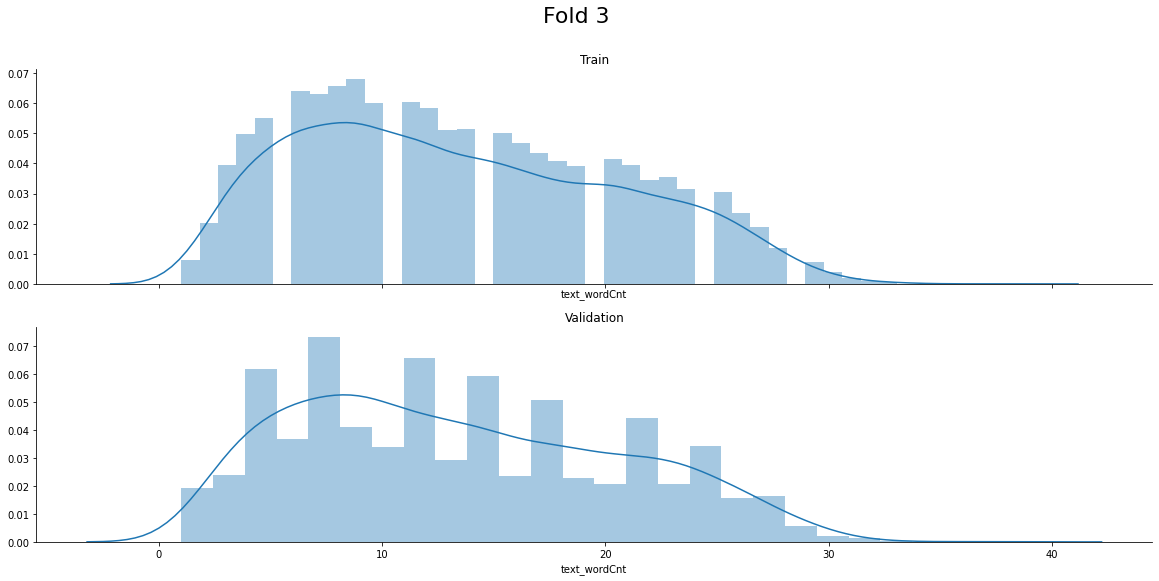

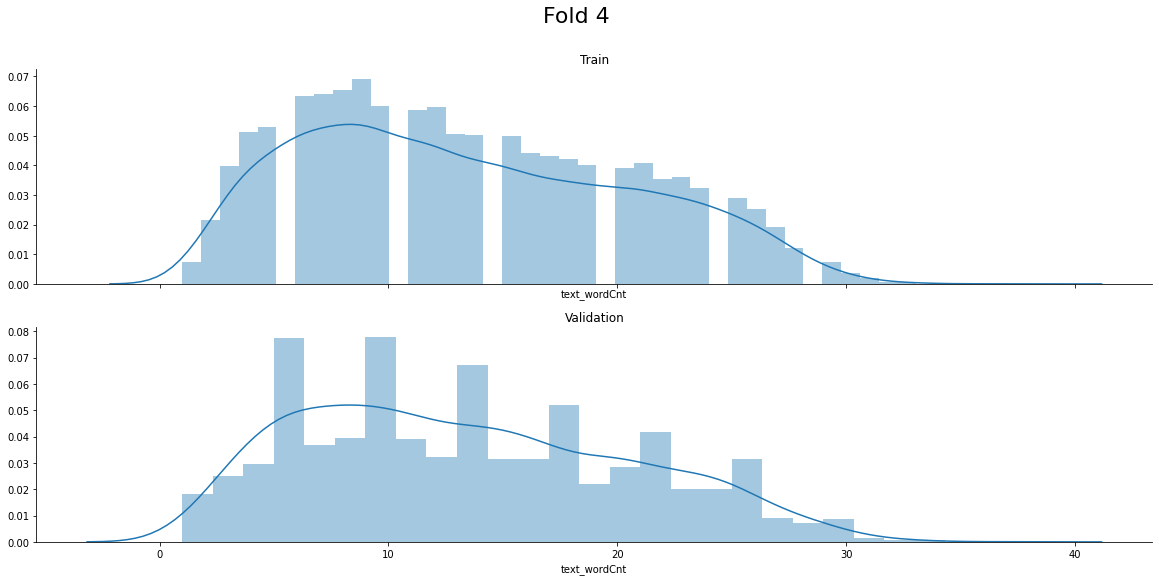

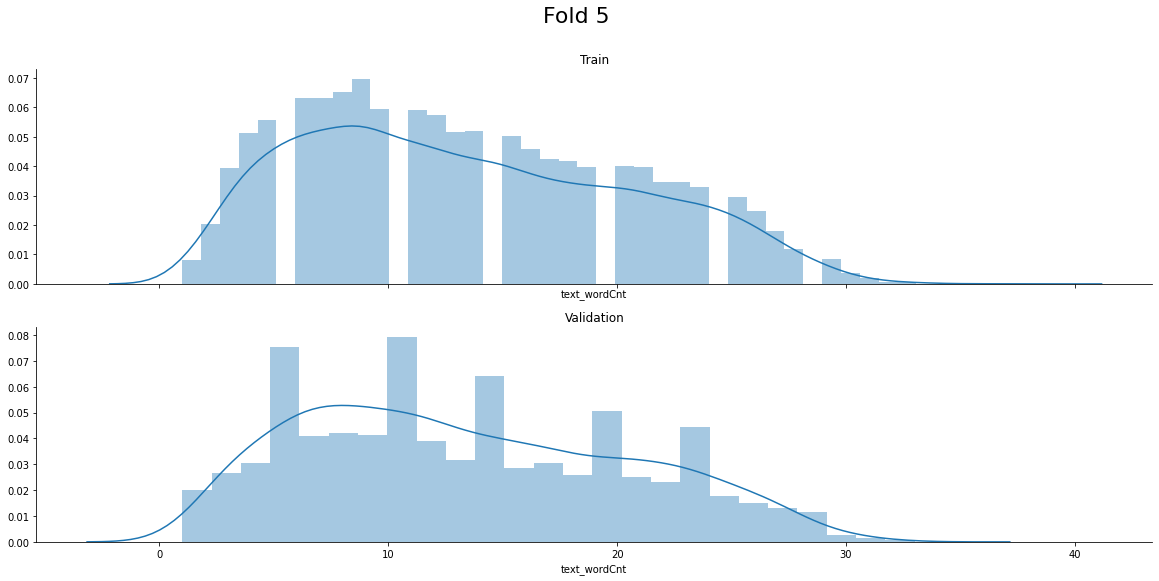

In [8]:
for fold_n in range(folds.n_splits):
    fold_n += 1
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8.7), sharex=True)
    fig.suptitle('Fold %s' % fold_n, fontsize=22)
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'train']['text_wordCnt'], ax=ax1).set_title("Train")
    sns.distplot(train_df[train_df[('fold_%s' % fold_n)] == 'validation']['text_wordCnt'], ax=ax2).set_title("Validation")
    sns.despine()
    plt.show()

# Output 5-fold set

In [9]:
train_df.to_csv('5-fold.csv', index=False)
display(train_df.head())

for fold_n in range(folds.n_splits):
    fold_n += 1
    
    base_path = 'fold_%d/' % fold_n
    # Create dir
    os.makedirs(base_path)
    
    x_train, x_train_aux, x_train_aux_2, y_train, y_train_mask, y_train_aux = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'train'], tokenizer, 
                                                                                       MAX_LEN, preprocess_fn=preprocess_roberta)
    x_valid, x_valid_aux, x_valid_aux_2, y_valid, y_valid_mask, y_valid_aux = get_data(train_df[train_df[('fold_%s' % fold_n)] == 'validation'], tokenizer, 
                                                                                       MAX_LEN, preprocess_fn=preprocess_roberta)
    
    
    np.save(base_path + 'x_train', np.array(x_train))
    np.save(base_path + 'y_train', np.array(y_train))
    np.save(base_path + 'x_valid', np.array(x_valid))
    np.save(base_path + 'y_valid', np.array(y_valid))
    
    np.save(base_path + 'x_train_aux', np.array(x_train_aux))
    np.save(base_path + 'x_train_aux2', np.array(x_train_aux_2))
    np.save(base_path + 'y_train_mask', np.array(y_train_mask))
    np.save(base_path + 'y_train_aux', np.array(y_train_aux))
    
    np.save(base_path + 'x_valid_aux', np.array(x_valid_aux))
    np.save(base_path + 'x_valid_aux2', np.array(x_valid_aux_2))
    np.save(base_path + 'y_valid_mask', np.array(y_valid_mask))
    np.save(base_path + 'y_valid_aux', np.array(y_valid_aux))
    
#  Compress logs dir
!tar -cvzf fold_1.tar.gz fold_1
!tar -cvzf fold_2.tar.gz fold_2
!tar -cvzf fold_3.tar.gz fold_3
!tar -cvzf fold_4.tar.gz fold_4
!tar -cvzf fold_5.tar.gz fold_5

# Delete logs dir
shutil.rmtree('fold_1')
shutil.rmtree('fold_2')
shutil.rmtree('fold_3')
shutil.rmtree('fold_4')
shutil.rmtree('fold_5')

,textID,text,selected_text,sentiment,jaccard,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,6c3221ae9b,so instead of laying out in this 90 degrees i`...,fml,negative,0.052632,115,3,21,1,train,validation,train,train,train
1,6d059e310b,hitting the (fairly empty) shops in orlando! o...,hitting,negative,0.076923,100,7,14,1,train,train,train,validation,train
2,ce7f8a5210,spent some time with the guild wars 4th birthd...,welcome,positive,0.052632,114,7,19,1,validation,train,train,train,train
3,456c4304cd,first weekend at home,first weekend at home,neutral,1.000000,21,21,4,4,train,validation,train,train,train
4,6b78e2821a,would like june the nineteenth to hurry it sel...,she is waiting very impatiently,negative,0.263158,102,31,20,5,train,train,train,train,validation


fold_1/
fold_1/y_valid.npy
fold_1/x_valid_aux.npy
fold_1/y_train.npy
fold_1/x_train_aux2.npy
fold_1/x_train.npy
fold_1/y_train_aux.npy
fold_1/y_train_mask.npy
fold_1/x_train_aux.npy
fold_1/x_valid.npy
fold_1/y_valid_mask.npy
fold_1/x_valid_aux2.npy
fold_1/y_valid_aux.npy
fold_2/
fold_2/y_valid.npy
fold_2/x_valid_aux.npy
fold_2/y_train.npy
fold_2/x_train_aux2.npy
fold_2/x_train.npy
fold_2/y_train_aux.npy
fold_2/y_train_mask.npy
fold_2/x_train_aux.npy
fold_2/x_valid.npy
fold_2/y_valid_mask.npy
fold_2/x_valid_aux2.npy
fold_2/y_valid_aux.npy
fold_3/
fold_3/y_valid.npy
fold_3/x_valid_aux.npy
fold_3/y_train.npy
fold_3/x_train_aux2.npy
fold_3/x_train.npy
fold_3/y_train_aux.npy
fold_3/y_train_mask.npy
fold_3/x_train_aux.npy
fold_3/x_valid.npy
fold_3/y_valid_mask.npy
fold_3/x_valid_aux2.npy
fold_3/y_valid_aux.npy
fold_4/
fold_4/y_valid.npy
fold_4/x_valid_aux.npy
fold_4/y_train.npy
fold_4/x_train_aux2.npy
fold_4/x_train.npy
fold_4/y_train_aux.npy
fold_4/y_train_mask.npy
fold_4/x_train_aux.npy
fo